<a href="https://colab.research.google.com/github/mimilazarova/DD2424-covid-xray-project/blob/master/playground_colab_mimi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

with open('/content/drive/My Drive/KTH/Year 1/DD2424 Deep Learning/DD2424_Project/data/trainX1.pickle', 'rb') as f:
  X1 = pickle.load(f)
with open('/content/drive/My Drive/KTH/Year 1/DD2424 Deep Learning/DD2424_Project/data/trainX2.pickle', 'rb') as f:
  X2 = pickle.load(f)

trainX = np.concatenate((X1, X2))

with open('/content/drive/My Drive/KTH/Year 1/DD2424 Deep Learning/DD2424_Project/data/testX.pickle', 'rb') as f:
  testX = pickle.load(f)
with open('/content/drive/My Drive/KTH/Year 1/DD2424 Deep Learning/DD2424_Project/data/train_y.pickle', 'rb') as f:
  train_y = pickle.load(f)
with open('/content/drive/My Drive/KTH/Year 1/DD2424 Deep Learning/DD2424_Project/data/test_y.pickle', 'rb') as f:
  test_y = pickle.load(f)


N = trainX.shape[0]
testN = testX.shape[0]

trainX = trainX.reshape((N, 224, 224, 1))
testX = testX.reshape((testN, 224, 224, 1))


In [4]:
trainX.shape

(13569, 224, 224, 1)

In [0]:
args = [train_y==0]
X0, vX0, y0, vy0 = train_test_split(trainX[args], train_y[args],  test_size=0.1, random_state=42) 

args = [train_y==1]
X1, vX1, y1, vy1 = train_test_split(trainX[args], train_y[args],  test_size=0.1, random_state=42) 

args = [train_y==2]
X2, vX2, y2, vy2 = train_test_split(trainX[args], train_y[args],  test_size=0.1, random_state=42) 

trainX = np.concatenate((X0, X1, X2))
train_y = np.concatenate((y0, y1, y2))

valX = np.concatenate((vX0, vX1, vX2))
val_y = np.concatenate((vy0, vy1, vy2))

In [6]:
trainX.shape

(12210, 224, 224, 1)

In [0]:
# one-hot-encoded vectors, not sure it we need them, the fitting the models with them did not work for me

# trainY = np.zeros((N, 3))
# testY = np.zeros((testN, 3))

# trainY[np.arange(N), train_y] = 1
# testY[np.arange(testN), test_y] = 1


In [0]:
model2 = keras.models.Sequential()
model2.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu', input_shape=(224, 224, 1)))
model2.add(layers.MaxPooling2D((4, 4)))
model2.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model2.add(layers.MaxPooling2D((4, 4)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(3))

class_weights = {}
for c in range(3):
  class_weights[c] = 1000/np.sum(train_y==c)
  print(class_weights[c])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


history2 = model2.fit(trainX, train_y, epochs=25, callbacks=[early_stopping],
                    class_weight=class_weights, validation_data=(valX, val_y))

Confusion matrix:
[[91  9  0]
 [ 8 89  3]
 [ 7  7 17]]
              precision    recall  f1-score   support

           0      0.858     0.910     0.883       100
           1      0.848     0.890     0.868       100
           2      0.850     0.548     0.667        31

    accuracy                          0.853       231
   macro avg      0.852     0.783     0.806       231
weighted avg      0.853     0.853     0.848       231



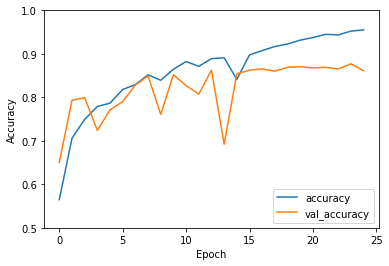

In [0]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_y_pred_m = model2.predict(testX)
test_y_pred2 = np.argmax(test_y_pred_m, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred2, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)
print(classification_report(test_y, test_y_pred2, digits=3))

Epoch 1/25
382/382 [==============================] - 10s 25ms/step - loss: 0.6170 - accuracy: 0.7883 - val_loss: 0.4670 - val_accuracy: 0.8256
Epoch 2/25
382/382 [==============================] - 9s 24ms/step - loss: 0.4936 - accuracy: 0.8421 - val_loss: 0.4358 - val_accuracy: 0.8344
Epoch 3/25
382/382 [==============================] - 9s 24ms/step - loss: 0.4483 - accuracy: 0.8542 - val_loss: 0.3990 - val_accuracy: 0.8477
Epoch 4/25
382/382 [==============================] - 9s 24ms/step - loss: 0.3982 - accuracy: 0.8675 - val_loss: 0.3934 - val_accuracy: 0.8344
Epoch 5/25
382/382 [==============================] - 9s 24ms/step - loss: 0.3590 - accuracy: 0.8781 - val_loss: 0.3450 - val_accuracy: 0.8668
Epoch 6/25
382/382 [==============================] - 9s 24ms/step - loss: 0.3209 - accuracy: 0.8907 - val_loss: 0.3442 - val_accuracy: 0.8661
Epoch 7/25
382/382 [==============================] - 9s 25ms/step - loss: 0.2886 - accuracy: 0.8948 - val_loss: 0.3207 - val_accuracy: 0.879

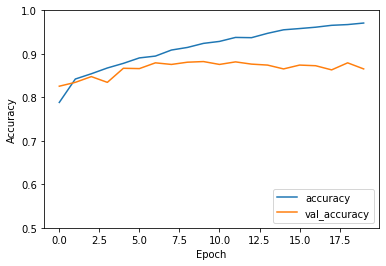

In [0]:
model3 = keras.models.Sequential()
model3.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu', input_shape=(224, 224, 1)))
model3.add(layers.MaxPooling2D((4, 4)))
model3.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model3.add(layers.MaxPooling2D((4, 4)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(3))

class_weights = {}
class_weights[0] = 1
class_weights[1] = 1
class_weights[2] = 4

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history3 = model3.fit(trainX, train_y, epochs=25, callbacks=[early_stopping],
                    class_weight=class_weights, validation_data=(valX, val_y))  

plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_y_pred_m = model3.predict(testX)
test_y_pred3 = np.argmax(test_y_pred_m, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred3, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)
print(classification_report(test_y, test_y_pred3, digits=3))

In [0]:
X_input = layers.Input((224, 224, 1))

X = layers.Conv2D(64, (7, 7), strides=(2, 2), padding = 'same', activation='elu', kernel_initializer='he_normal')(X_input)

X1 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='elu', kernel_initializer='he_normal')(X)

pepx1 = layers.Conv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(X1)
pepx1 = layers.Conv2D(256, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx1)
pepx1 = layers.DepthwiseConv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx1)
pepx1 = layers.Conv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx1)
pepx1 = layers.Conv2D(256, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx1)

X = layers.Add()([pepx1, X1])

X2 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='elu', kernel_initializer='he_normal')(X)

pepx2 = layers.Conv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(X2)
pepx2 = layers.Conv2D(256, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx2)
pepx2 = layers.DepthwiseConv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx2)
pepx2 = layers.Conv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx2)
pepx2 = layers.Conv2D(256, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx2)


X = layers.Add()([pepx2, X2])
X3 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='elu', kernel_initializer='he_normal')(X)

pepx3 = layers.Conv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(X3)
pepx3 = layers.Conv2D(256, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx3)
pepx3 = layers.DepthwiseConv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx3)
pepx3 = layers.Conv2D(16, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx3)
pepx3 = layers.Conv2D(256, (1, 1), padding='same', activation='elu', kernel_initializer='he_normal')(pepx3)

X = layers.Flatten()(pepx3)
X = layers.Dense(128, activation='elu', kernel_initializer='he_normal')(X)
X = layers.Dense(32, activation='elu', kernel_initializer='he_normal')(X)
X = layers.Dense(3, activation='softmax', kernel_initializer='he_normal')(X)

model5 = keras.models.Model(inputs=X_input, outputs=X)
model5.summary()

0.010022846193529368
0.36148573955339375
0.528336649716265
Epoch 1/5
382/382 [==============================] - 172s 451ms/step - loss: 0.0983 - accuracy: 0.4017 - val_loss: 1.1497 - val_accuracy: 0.4018
Epoch 2/5
382/382 [==============================] - 171s 448ms/step - loss: 0.0983 - accuracy: 0.4017 - val_loss: 1.1497 - val_accuracy: 0.4018
Epoch 3/5
382/382 [==============================] - 171s 448ms/step - loss: 0.0983 - accuracy: 0.4017 - val_loss: 1.1497 - val_accuracy: 0.4018
Epoch 4/5
382/382 [==============================] - 171s 449ms/step - loss: 0.0983 - accuracy: 0.4017 - val_loss: 1.1497 - val_accuracy: 0.4018
Epoch 5/5
382/382 [==============================] - 171s 448ms/step - loss: 0.0983 - accuracy: 0.4017 - val_loss: 1.1497 - val_accuracy: 0.4018
Confusion matrix:
[[  0 100   0]
 [  0 100   0]
 [  0  31   0]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       100
           1      0.433     1.000     0.604

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


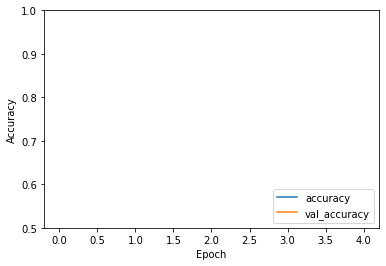

In [0]:
class_weights = {}
for c in range(3):
  class_weights[c] = np.sum(train_y==(2-c))/N
  print(class_weights[c])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history5 = model5.fit(trainX, train_y, epochs=5, callbacks=[early_stopping],
                    class_weight=class_weights, validation_data=(valX, val_y))  

plt.plot(history5.history['accuracy'], label='accuracy')
plt.plot(history5.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_y_pred_m = model5.predict(testX)
test_y_pred5 = np.argmax(test_y_pred_m, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred5, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)
print(classification_report(test_y, test_y_pred5, digits=3))


In [0]:
N = train_y.shape[0]
testN = test_y.shape[0]
for c in range(3):
  print(np.sum(test_y==c)/testN)
print("\n")
for c in range(3):
  print(np.sum(train_y==c)/N)

0.4329004329004329
0.4329004329004329
0.1341991341991342


0.5871416871416871
0.40171990171990174
0.011138411138411138


In [0]:
X_input = layers.Input((224, 224, 1))

X = layers.Conv2D(64, (7, 7), strides=(2, 2), padding = 'same', kernel_initializer='he_uniform')(X_input)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

X1 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform')(X)
X1 = layers.BatchNormalization()(X1)

b1 = layers.MaxPool2D((2,2))(X) 
b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)
b1 = layers.Activation('relu')(b1)
b1 = layers.Conv2D(256, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)


X = layers.Add()([X1, b1])
X = layers.Activation('relu')(X)

X2 = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
X2 = layers.BatchNormalization()(X2)

b2 = layers.MaxPool2D((2,2))(X) 
b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)
b2 = layers.Activation('relu')(b2)
b2 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)


X = layers.Add()([X2, b2])
X = layers.Activation('relu')(X)


X = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D(2, 2)(X)

X = layers.Flatten()(X)
X = layers.Dense(128, kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.Dense(3,kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('softmax')(X)

model6 = keras.models.Model(inputs=X_input, outputs=X, name='model_6')
model6.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 112, 112, 64) 3200        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [0]:
class_weights = {}
# for c in range(3):
#   class_weights[c] = 1000/np.sum(train_y==c)
#   print(class_weights[c])
class_weights[0] = 1
class_weights[1] = 1
class_weights[2] = 4

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


model6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history6 = model6.fit(trainX, train_y, batch_size=8, epochs=25, callbacks=[early_stopping],
                    class_weight=class_weights, validation_data=(valX, val_y))  



Epoch 1/25
1527/1527 [==============================] - 52s 34ms/step - loss: 0.8540 - accuracy: 0.8022 - val_loss: 0.7337 - val_accuracy: 0.8263
Epoch 2/25
1527/1527 [==============================] - 51s 33ms/step - loss: 0.7682 - accuracy: 0.8437 - val_loss: 0.7887 - val_accuracy: 0.7829
Epoch 3/25
1527/1527 [==============================] - 51s 33ms/step - loss: 0.7378 - accuracy: 0.8618 - val_loss: 0.6918 - val_accuracy: 0.8602
Epoch 4/25
1527/1527 [==============================] - 51s 33ms/step - loss: 0.7220 - accuracy: 0.8706 - val_loss: 0.6805 - val_accuracy: 0.8837
Epoch 5/25
1527/1527 [==============================] - 51s 33ms/step - loss: 0.7139 - accuracy: 0.8741 - val_loss: 0.6549 - val_accuracy: 0.8940
Epoch 6/25
1527/1527 [==============================] - 51s 33ms/step - loss: 0.6993 - accuracy: 0.8862 - val_loss: 0.6637 - val_accuracy: 0.8859
Epoch 7/25
1527/1527 [==============================] - 51s 33ms/step - loss: 0.6916 - accuracy: 0.8916 - val_loss: 0.7260 -

Confusion matrix:
[[96  4  0]
 [13 87  0]
 [ 9 10 12]]
              precision    recall  f1-score   support

           0      0.814     0.960     0.881       100
           1      0.861     0.870     0.866       100
           2      1.000     0.387     0.558        31

    accuracy                          0.844       231
   macro avg      0.892     0.739     0.768       231
weighted avg      0.859     0.844     0.831       231



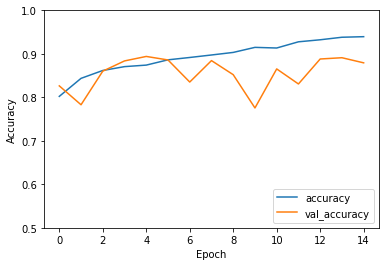

In [0]:
plt.plot(history6.history['accuracy'], label='accuracy')
plt.plot(history6.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_y_pred_m = model6.predict(testX)
test_y_pred6 = np.argmax(test_y_pred_m, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred6, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)
print(classification_report(test_y, test_y_pred6, digits=3))

In [7]:
X_input = layers.Input((224, 224, 1))

X = layers.Conv2D(64, (7, 7), strides=(2, 2), padding = 'same', kernel_initializer='he_uniform')(X_input)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

X1 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform')(X)
X1 = layers.BatchNormalization()(X1)

b1 = layers.MaxPool2D((2,2))(X) 
b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)
b1 = layers.Activation('relu')(b1)
b1 = layers.Conv2D(256, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)


X = layers.Add()([X1, b1])
X = layers.Activation('relu')(X)

X2 = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
X2 = layers.BatchNormalization()(X2)

b2 = layers.MaxPool2D((2,2))(X) 
b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)
b2 = layers.Activation('relu')(b2)
b2 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)


X = layers.Add()([X2, b2])
X = layers.Activation('relu')(X)

X3 = layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
X3 = layers.BatchNormalization()(X3)

b3 = layers.MaxPool2D((2,2))(X) 
b3 = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)
b3 = layers.Activation('relu')(b3)
b3 = layers.Conv2D(1024, (1, 1), padding='same',  kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)


X = layers.Add()([X3, b3])
X = layers.Activation('relu')(X)

X = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D(2, 2)(X)

X = layers.Flatten()(X)
X = layers.Dense(128, kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.Dense(3,kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('softmax')(X)

model7 = keras.models.Model(inputs=X_input, outputs=X, name='model_7')
model7.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

0.13948946854512484
0.2038735983690112
7.352941176470588
Epoch 1/25
1527/1527 [==============================] - 541s 354ms/step - loss: 0.2305 - accuracy: 0.5743 - val_loss: 1.2976 - val_accuracy: 0.1876
Epoch 2/25
1527/1527 [==============================] - 539s 353ms/step - loss: 0.2173 - accuracy: 0.6677 - val_loss: 0.9286 - val_accuracy: 0.5968
Epoch 3/25
1527/1527 [==============================] - 513s 336ms/step - loss: 0.2090 - accuracy: 0.6811 - val_loss: 0.8983 - val_accuracy: 0.6512
Epoch 4/25
1527/1527 [==============================] - 517s 338ms/step - loss: 0.1985 - accuracy: 0.7303 - val_loss: 0.9682 - val_accuracy: 0.5570
Epoch 5/25
1527/1527 [==============================] - 523s 343ms/step - loss: 0.1916 - accuracy: 0.7472 - val_loss: 1.0182 - val_accuracy: 0.5166
Epoch 6/25
1527/1527 [==============================] - 520s 341ms/step - loss: 0.1863 - accuracy: 0.7719 - val_loss: 0.8991 - val_accuracy: 0.6468
Epoch 7/25
1527/1527 [==============================] -

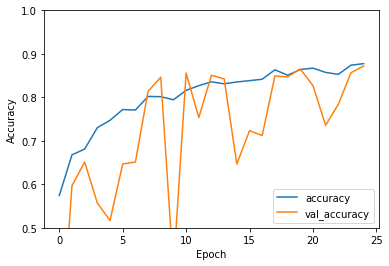

In [8]:
class_weights = {}
for c in range(3):
  class_weights[c] = 1000/np.sum(train_y==c)
  print(class_weights[c])
# class_weights[0] = 1
# class_weights[1] = 2
# class_weights[2] = 8

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


model7.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history7 = model7.fit(trainX, train_y, batch_size=8, epochs=25, callbacks=[early_stopping],
                    class_weight=class_weights, validation_data=(valX, val_y))  


plt.plot(history7.history['accuracy'], label='accuracy')
plt.plot(history7.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_y_pred_m = model7.predict(testX)
test_y_pred7 = np.argmax(test_y_pred_m, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred7, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)
print(classification_report(test_y, test_y_pred7, digits=3))

In [0]:
X_input = layers.Input((224, 224, 1))

X = layers.Conv2D(64, (7, 7), strides=(2, 2), padding = 'same', kernel_initializer='he_uniform')(X_input)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

X1 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform')(X)
X1 = layers.BatchNormalization()(X1)

b1 = layers.MaxPool2D((2,2))(X) 
b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)
b1 = layers.Activation('relu')(b1)
b1 = layers.Conv2D(256, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)

X = layers.Add()([X1, b1])
X = layers.Activation('relu')(X)

X1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(X)
X1 = layers.BatchNormalization()(X1)

b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)
b1 = layers.Activation('relu')(b1)
b1 = layers.Conv2D(256, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)


X = layers.Add()([X1, b1])
X = layers.Activation('relu')(X)

X2 = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
X2 = layers.BatchNormalization()(X2)

b2 = layers.MaxPool2D((2,2))(X) 
b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)
b2 = layers.Activation('relu')(b2)
b2 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)


X = layers.Add()([X2, b2])
X = layers.Activation('relu')(X)

X2 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(X)
X2 = layers.BatchNormalization()(X2)

b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)
b2 = layers.Activation('relu')(b2)
b2 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)

X = layers.Add()([X2, b2])
X = layers.Activation('relu')(X)

X3 = layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
X3 = layers.BatchNormalization()(X3)

b3 = layers.MaxPool2D((2,2))(X) 
b3 = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)
b3 = layers.Activation('relu')(b3)
b3 = layers.Conv2D(1024, (1, 1), padding='same',  kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)


X = layers.Add()([X3, b3])
X = layers.Activation('relu')(X)

X3 = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_normal')(X)
X3 = layers.BatchNormalization()(X3)

b3 = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)
b3 = layers.Activation('relu')(b3)
b3 = layers.Conv2D(1024, (1, 1), padding='same',  kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)

X = layers.Add()([X3, b3])
X = layers.Activation('relu')(X)

X = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D(2, 2)(X)

X = layers.Flatten()(X)
X = layers.Dense(128, kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.Dense(3,kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('softmax')(X)

model8 = keras.models.Model(inputs=X_input, outputs=X, name='model_8')
model8.summary()

In [19]:
class_weights = {}
# for c in range(3):
#   class_weights[c] = 1000/np.sum(train_y==c)
#   print(class_weights[c])
class_weights[0] = 1
class_weights[1] = 2
class_weights[2] = 12

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

aug = keras.preprocessing.image.ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.01, horizontal_flip=True,
                         vertical_flip=False, fill_mode="nearest")

dirname = "/content/drive/My Drive/KTH/Year 1/DD2424 Deep Learning/DD2424_Project/"

filename = "model8-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(dirname, filename),  
                                        monitor="val_accuracy",
                                        safe_best_only = True,
                                        verbose=1)

optimizer = keras.optimizers.Adam(0.00002)

model8.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history8 = model8.fit(aug.flow(trainX, train_y), batch_size=8,
                      epochs=25, callbacks=[early_stopping, checkpoint],
                      class_weight=class_weights, validation_data=(valX, val_y))  


plt.plot(history8.history['accuracy'], label='accuracy')
plt.plot(history8.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_y_pred_m = model8.predict(testX)
test_y_pred8 = np.argmax(test_y_pred_m, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred8, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)
print(classification_report(test_y, test_y_pred8, digits=3))

Epoch 1/25
    127/Unknown - 332s 3s/step - loss: 1.4472 - accuracy: 0.5802

KeyboardInterrupt: ignored

In [20]:
aug.flow(trainX, train_y)

In [0]:
filename = "/content/drive/My Drive/KTH/Year 1/DD2424 Deep Learning/DD2424_Project/model8.h5"
# model8.save(filename)

In [0]:
loaded = keras.models.load_model(filename) # model8.load_weights(os.path.join(filename, saved)
test_y_pred_m = loaded.predict(testX)
test_y_pred8 = np.argmax(test_y_pred_m, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred8, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)
print(classification_report(test_y, test_y_pred8, digits=3))

Confusion matrix:
[[98  2  0]
 [10 90  0]
 [ 6  1 24]]
              precision    recall  f1-score   support

           0      0.860     0.980     0.916       100
           1      0.968     0.900     0.933       100
           2      1.000     0.774     0.873        31

    accuracy                          0.918       231
   macro avg      0.942     0.885     0.907       231
weighted avg      0.925     0.918     0.917       231



In [0]:
loaded_model8


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb81ba6c5c0>